In [176]:
# importing libraries:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import PolynomialRegression
# from sklearn.linear_model import StepwiseRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.express as px
import pandas_profiling
from sklearn.feature_selection import f_regression, SelectKBest

In [75]:
df=pd.read_csv('https://raw.githubusercontent.com/VeraMendes/Project---Train-a-predictive-model/master/led.csv')
print(df.shape)
df.head()

(2938, 22)


Country  Year      Status  Lifeexpectancy  AdultMortality  \
0  Afghanistan  2015  Developing            65.0           263.0   
1  Afghanistan  2014  Developing            59.9           271.0   
2  Afghanistan  2013  Developing            59.9           268.0   
3  Afghanistan  2012  Developing            59.5           272.0   
4  Afghanistan  2011  Developing            59.2           275.0   

   infantdeaths  Alcohol  percentageexpenditure  HepatitisB  Measles  ...  \
0            62     0.01              71.279624        65.0     1154  ...   
1            64     0.01              73.523582        62.0      492  ...   
2            66     0.01              73.219243        64.0      430  ...   
3            69     0.01              78.184215        67.0     2787  ...   
4            71     0.01               7.097109        68.0     3013  ...   

   Polio  Totalexpenditure  Diphtheria  HIV/AIDS         GDP  Population  \
0    6.0              8.16        65.0       0.1  584.259210  33736494.0   
1   58.0              8.18        62.0       0.1  612.696514    327582.0   
2   62.0              8.13        64.0       0.1  631.744976  31731688.0   
3   67.0              8.52        67.0       0.1  669.959000   3696958.0   
4   68.0              7.87        68.0       0.1   63.537231   2978599.0   

   thinness1-19years  thinness5-9years  Incomecompositionofresources  \
0               17.2              17.3                         0.479   
1               17.5              17.5                         0.476   
2               17.7              17.7                         0.470   
3               17.9              18.0                         0.463   
4               18.2              18.2                         0.454   

   Schooling  
0       10.1  
1       10.0  
2        9.9  
3        9.8  
4        9.5  

[5 rows x 22 columns]

In [76]:
# changing my column names
df = df.rename(columns = {
    'Country':'country','Year':'year', 'Status':'development','Lifeexpectancy':'lifespan',
    'AdultMortality':'adult_mortality', 'infantdeaths':'infant_deaths',
    'Alcohol':'alcohol_consumption', 'percentageexpenditure':'percentage_expenditure',
    'HepatitisB':'hepatitisb','Measles':'measles','BMI':'BMI','under-fivedeaths':'baby_deaths',
    'Polio':'polio', 'Totalexpenditure':'total_expenditure','Diphtheria':'diphtheria','HIV/AIDS':'HIV',
    'GDP':'GDP','Population':'population','thinness1-19years':'thinness_teenager',
    'thinness5-9years':'thinness_children','Incomecompositionofresources':'ICR','Schooling':'education'
})

df.head()

country  year development  lifespan  adult_mortality  infant_deaths  \
0  Afghanistan  2015  Developing      65.0            263.0             62   
1  Afghanistan  2014  Developing      59.9            271.0             64   
2  Afghanistan  2013  Developing      59.9            268.0             66   
3  Afghanistan  2012  Developing      59.5            272.0             69   
4  Afghanistan  2011  Developing      59.2            275.0             71   

   alcohol_consumption  percentage_expenditure  hepatitisb  measles  ...  \
0                 0.01               71.279624        65.0     1154  ...   
1                 0.01               73.523582        62.0      492  ...   
2                 0.01               73.219243        64.0      430  ...   
3                 0.01               78.184215        67.0     2787  ...   
4                 0.01                7.097109        68.0     3013  ...   

   polio  total_expenditure  diphtheria  HIV         GDP  population  \
0    6.0               8.16        65.0  0.1  584.259210  33736494.0   
1   58.0               8.18        62.0  0.1  612.696514    327582.0   
2   62.0               8.13        64.0  0.1  631.744976  31731688.0   
3   67.0               8.52        67.0  0.1  669.959000   3696958.0   
4   68.0               7.87        68.0  0.1   63.537231   2978599.0   

   thinness_teenager  thinness_children    ICR  education  
0               17.2               17.3  0.479       10.1  
1               17.5               17.5  0.476       10.0  
2               17.7               17.7  0.470        9.9  
3               17.9               18.0  0.463        9.8  
4               18.2               18.2  0.454        9.5  

[5 rows x 22 columns]

In [77]:
# dropping nan's for lifespan
df = df.dropna(axis=0, subset=['lifespan'])
# checking dimnesions of my df
df.shape
# due to leakage problems, I am creating a new column which is going to be my y_target: next_year_lifespan
df['next_year_lifespan']= df['lifespan'].shift(1)
# 2015 does not have data on y_target for any country
# With pd.shift, I have moved into 2015 wrong values for the countries considered.
year_2015 = df[df.year == 2015]
# For my analysis I am dropping 2015 rows to avoid errors and leakage.
df = df[df.year != 2015]
df.head()

country  year development  lifespan  adult_mortality  infant_deaths  \
1  Afghanistan  2014  Developing      59.9            271.0             64   
2  Afghanistan  2013  Developing      59.9            268.0             66   
3  Afghanistan  2012  Developing      59.5            272.0             69   
4  Afghanistan  2011  Developing      59.2            275.0             71   
5  Afghanistan  2010  Developing      58.8            279.0             74   

   alcohol_consumption  percentage_expenditure  hepatitisb  measles  ...  \
1                 0.01               73.523582        62.0      492  ...   
2                 0.01               73.219243        64.0      430  ...   
3                 0.01               78.184215        67.0     2787  ...   
4                 0.01                7.097109        68.0     3013  ...   
5                 0.01               79.679367        66.0     1989  ...   

   total_expenditure  diphtheria  HIV         GDP  population  \
1               8.18        62.0  0.1  612.696514    327582.0   
2               8.13        64.0  0.1  631.744976  31731688.0   
3               8.52        67.0  0.1  669.959000   3696958.0   
4               7.87        68.0  0.1   63.537231   2978599.0   
5               9.20        66.0  0.1  553.328940   2883167.0   

   thinness_teenager  thinness_children    ICR  education  next_year_lifespan  
1               17.5               17.5  0.476       10.0                65.0  
2               17.7               17.7  0.470        9.9                59.9  
3               17.9               18.0  0.463        9.8                59.9  
4               18.2               18.2  0.454        9.5                59.5  
5               18.4               18.4  0.448        9.2                59.2  

[5 rows x 23 columns]

In [78]:
# looking into nan's
df.isnull().sum()

country                     0
year                        0
development                 0
lifespan                    0
adult_mortality             0
infant_deaths               0
alcohol_consumption        16
percentage_expenditure      0
hepatitisb                544
measles                     0
BMI                        30
baby_deaths                 0
polio                      19
total_expenditure          45
diphtheria                 19
HIV                         0
GDP                       414
population                603
thinness_teenager          30
thinness_children          30
ICR                       150
education                 150
next_year_lifespan          0
dtype: int64

### Looking into Time Series I am:
### using 2013 & 2014 as test
### using 2011 & 2012 as val
### I cannot use 2015 values as I don't have values for the next year lifespan (2016)

In [79]:
# splitting my data into a time series manner
train = df[df['year']<2011]
val = df[(df.year == 2011) | (df.year == 2012)]
test = df[(df.year == 2013) | (df.year == 2014)]
train.shape, val.shape, test.shape

((2013, 23), (366, 23), (366, 23))

In [65]:
# general view of my train dataset
pandas_profiling.ProfileReport(train)

In [92]:
# Arrange data into X features matrix and y target vector
# removing previous year lifespan from all my data
target = 'next_year_lifespan'
baseline_values = 'lifespan'
cols_to_drop = ['next_year_lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [93]:
# using previous year lifespan, as y_pred = y_baseline
y_baseline = pd.Series(train['lifespan'], index=train.index)
# using previous year lifespan, as y_pred = y_baseline to try to find a better model fit
mean_baseline = train['next_year_lifespan'].mean()
y_pred = val['lifespan']
baseline_mae = mean_absolute_error(y_val, y_pred)
r2_val = r2_score(y_val, y_pred)
print('mean baseline:', train['next_year_lifespan'].mean())
print(f'Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): {baseline_mae:.4f}')
print('Test R\u00b2:', r2_test)

mean baseline: 68.68564331843021
Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): 0.8281
Test R²: 0.7920759551750944


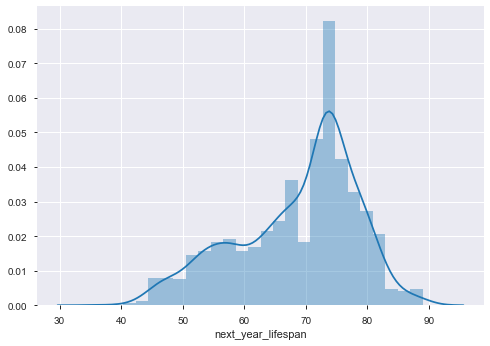

In [94]:
sns.distplot(y_train);

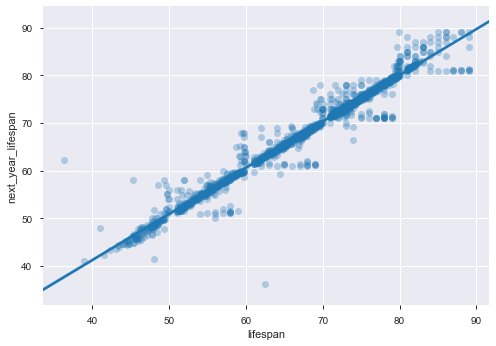

In [95]:
sns.regplot(x=train['lifespan'],y=train['next_year_lifespan'], scatter_kws={'alpha':0.3});

In [96]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [97]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
r2_val = r2_score(y_val, y_pred)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))
print('Test R\u00b2:', r2_test)

Mean Absolut error: 0.826355152318975
Test R²: 0.7920759551750944


In [98]:
# using feature permutation on my model
permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                      n_iter=5, random_state=42, refit=True,
                      scoring='neg_mean_absolute_error')

In [99]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

lifespan                  8.029416
baby_deaths               0.161055
infant_deaths             0.132750
education                 0.039954
HIV                       0.020137
adult_mortality           0.016522
polio                     0.013247
percentage_expenditure    0.012566
ICR                       0.007078
development               0.006720
total_expenditure         0.004848
diphtheria                0.003757
thinness_teenager         0.003579
thinness_children         0.002667
alcohol_consumption       0.001677
GDP                       0.001452
hepatitisb                0.000750
country                   0.000467
population                0.000021
measles                  -0.000010
year                     -0.000039
BMI                      -0.001309
dtype: float64

In [100]:
# looking into feature importance and weight
eli5.show_weights(
    permuter, 
    top=None,
    feature_names = feature_names
)

In [101]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['next_year_lifespan', 'BMI', 'year', 'measles', 'population']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [106]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [107]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
r2_val = r2_score(y_val, y_pred)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))
print('Test R\u00b2:', r2_test)

Mean Absolut error: 0.8082317583411956
Test R²: 0.7920759551750944


In [112]:
train.head()

country  year development  lifespan  adult_mortality  infant_deaths  \
5  Afghanistan  2010  Developing      58.8            279.0             74   
6  Afghanistan  2009  Developing      58.6            281.0             77   
7  Afghanistan  2008  Developing      58.1            287.0             80   
8  Afghanistan  2007  Developing      57.5            295.0             82   
9  Afghanistan  2006  Developing      57.3            295.0             84   

   alcohol_consumption  percentage_expenditure  hepatitisb  measles  ...  \
5                 0.01               79.679367        66.0     1989  ...   
6                 0.01               56.762217        63.0     2861  ...   
7                 0.03               25.873925        64.0     1599  ...   
8                 0.02               10.910156        63.0     1141  ...   
9                 0.03               17.171518        64.0     1990  ...   

   total_expenditure  diphtheria  HIV         GDP  population  \
5               9.20        66.0  0.1  553.328940   2883167.0   
6               9.42        63.0  0.1  445.893298    284331.0   
7               8.33        64.0  0.1  373.361116   2729431.0   
8               6.73        63.0  0.1  369.835796  26616792.0   
9               7.43        58.0  0.1  272.563770   2589345.0   

   thinness_teenager  thinness_children    ICR  education  next_year_lifespan  
5               18.4               18.4  0.448        9.2                59.2  
6               18.6               18.7  0.434        8.9                58.8  
7               18.8               18.9  0.433        8.7                58.6  
8               19.0               19.1  0.415        8.4                58.1  
9               19.2               19.3  0.405        8.1                57.5  

[5 rows x 23 columns]

In [122]:
train.columns

Index(['country', 'year', 'development', 'lifespan', 'adult_mortality',
       'infant_deaths', 'alcohol_consumption', 'percentage_expenditure',
       'hepatitisb', 'measles', 'BMI', 'baby_deaths', 'polio',
       'total_expenditure', 'diphtheria', 'HIV', 'GDP', 'population',
       'thinness_teenager', 'thinness_children', 'ICR', 'education',
       'next_year_lifespan'],
      dtype='object')

In [124]:
px.scatter_matrix(train, dimensions=['lifespan', 'baby_deaths', 'infant_deaths', 'education'], color="development")

In [125]:
px.scatter(train, x="lifespan", y="next_year_lifespan", color="year", trendline="ols", marginal_x="violin", marginal_y="box")

In [148]:
px.scatter(train, x="adult_mortality", y="GDP", color="next_year_lifespan", trendline="ols", marginal_x="violin", marginal_y="box")

In [160]:
px.scatter(train, x="adult_mortality", y="next_year_lifespan", color="development", trendline="ols", marginal_x="violin", marginal_y="box")

In [123]:
px.violin(train, y="next_year_lifespan", x="year", color="development", box=True, points="all")

In [132]:
px.scatter(train,
          x="adult_mortality",
          y="next_year_lifespan",
          color='development',
          hover_name="country",
          animation_frame="year",
          animation_group="country",
          range_x=[0,725],
          range_y=[30,90])

In [134]:
px.scatter(train,
          x="alcohol_consumption",
          y="next_year_lifespan",
          color='development',
          hover_name="country",
          animation_frame="year",
          animation_group="country",
          range_x=[0,18],
          range_y=[30,90])

In [137]:
px.violin(train, y="next_year_lifespan", x="development", color="year", box=True, points="all")

In [138]:
px.scatter_matrix(train, dimensions=['polio', 'measles', 'hepatitisb', 'diphtheria', 'HIV'], color="development")

In [139]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['next_year_lifespan', 'BMI', 'year', 'measles', 'population', 'thinness_teenager', 'percentage_expenditure',
               'infant_deaths']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [140]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [141]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
r2_val = r2_score(y_val, y_pred)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))
print('Test R\u00b2:', r2_test)

Mean Absolut error: 0.8005917974172213
Test R²: 0.7920759551750944


In [164]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['country', 'year', 'development','BMI','hepatitisb', 'measles',
                'total_expenditure', 'diphtheria', 'GDP','population',
                'thinness_teenager', 'thinness_children','next_year_lifespan',
                'alcohol_consumption']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [165]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [166]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
r2_val = r2_score(y_val, y_pred)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))
print('Test R\u00b2:', r2_test)

Mean Absolut error: 0.7982997737737991
Test R²: 0.7920759551750944


In [167]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['country', 'year', 'development','infant_deaths',
                'percentage_expenditure','hepatitisb', 'measles',
                'polio','total_expenditure', 'diphtheria', 'GDP',
                'population', 'thinness_teenager', 'next_year_lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [168]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [169]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
r2_val = r2_score(y_val, y_pred)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))
print('Test R\u00b2:', r2_test)

Mean Absolut error: 0.7694277849740445
Test R²: 0.7920759551750944


In [170]:
# using feature permutation on my model
permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                      n_iter=5, random_state=42, refit=True,
                      scoring='neg_mean_absolute_error')

In [171]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

lifespan               8.300482
education              0.065039
ICR                    0.017946
adult_mortality        0.017553
alcohol_consumption    0.016479
HIV                    0.012740
BMI                    0.004370
thinness_children      0.004276
baby_deaths            0.000463
dtype: float64

In [172]:
# looking into feature importance and weight
eli5.show_weights(
    permuter, 
    top=None,
    feature_names = feature_names
)

In [173]:
train.corr()

year  lifespan  adult_mortality  infant_deaths  \
year                    1.000000  0.111779        -0.037286      -0.024151   
lifespan                0.111779  1.000000        -0.677141      -0.185296   
adult_mortality        -0.037286 -0.677141         1.000000       0.055745   
infant_deaths          -0.024151 -0.185296         0.055745       1.000000   
alcohol_consumption     0.036364  0.401758        -0.191140      -0.127255   
percentage_expenditure  0.079075  0.403295        -0.254509      -0.089537   
hepatitisb              0.119263  0.235122        -0.143408      -0.246971   
measles                -0.082943 -0.157584         0.007189       0.488687   
BMI                     0.058434  0.585561        -0.382535      -0.230040   
baby_deaths            -0.027247 -0.211876         0.069689       0.996887   
polio                   0.120036  0.472563        -0.244610      -0.181519   
total_expenditure       0.073386  0.206703        -0.109146      -0.129179   
diphtheria              0.127565  0.483308        -0.252189      -0.182916   
HIV                    -0.068287 -0.576526         0.538571       0.016940   
GDP                     0.105835  0.462401        -0.289860      -0.108954   
population              0.014619 -0.017917        -0.024198       0.570865   
thinness_teenager      -0.022230 -0.481498         0.304765       0.470589   
thinness_children      -0.030137 -0.472759         0.309945       0.483119   
ICR                     0.187243  0.674957        -0.405739      -0.128139   
education               0.165990  0.727770        -0.414929      -0.189349   
next_year_lifespan      0.119423  0.981535        -0.670029      -0.185003   

                        alcohol_consumption  percentage_expenditure  \
year                               0.036364                0.079075   
lifespan                           0.401758                0.403295   
adult_mortality                   -0.191140               -0.254509   
infant_deaths                     -0.127255               -0.089537   
alcohol_consumption                1.000000                0.358002   
percentage_expenditure             0.358002                1.000000   
hepatitisb                         0.094867                0.003514   
measles                           -0.060222               -0.060022   
BMI                                0.364904                0.265915   
baby_deaths                       -0.123812               -0.092330   
polio                              0.239351                0.170120   
total_expenditure                  0.319131                0.164667   
diphtheria                         0.253343                0.161251   
HIV                               -0.056517               -0.110278   
GDP                                0.379316                0.936734   
population                        -0.032099               -0.024791   
thinness_teenager                 -0.441465               -0.270837   
thinness_children                 -0.425584               -0.270537   
ICR                                0.454848                0.401523   
education                          0.572896                0.421885   
next_year_lifespan                 0.406717                0.410961   

                        hepatitisb   measles       BMI  baby_deaths  ...  \
year                      0.119263 -0.082943  0.058434    -0.027247  ...   
lifespan                  0.235122 -0.157584  0.585561    -0.211876  ...   
adult_mortality          -0.143408  0.007189 -0.382535     0.069689  ...   
infant_deaths            -0.246971  0.488687 -0.230040     0.996887  ...   
alcohol_consumption       0.094867 -0.060222  0.364904    -0.123812  ...   
percentage_expenditure    0.003514 -0.060022  0.265915    -0.092330  ...   
hepatitisb                1.000000 -0.139196  0.161369    -0.254563  ...   
measles                  -0.139196  1.000000 -0.179751     0.499223  ...   
BMI                       0.161369 -0.179751  1.000000    -0.241

In [174]:
print('Model Coeficient:', model.coef_)
print('Model Intercept:', model.intercept_)

Model Coeficient: [ 9.18308162e-01 -6.27943932e-04  2.45160807e-02  2.00003217e-03
 -1.22402351e-04 -4.31671924e-02 -1.08829599e-02  5.04212029e-01
  6.03449467e-02]
Model Intercept: 5.000359125731194


In [177]:
selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)
X_train_selected.shape, X_test_selected.shape

((2013, 5), (366, 5))

In [178]:
# features selected by selectkbest
all_features = X_train.columns
selected_mask = selector.get_support()
selected_features = all_features[selected_mask]

print('Features selected:')
for feature in selected_features:
    print(feature)

Features selected:
lifespan
adult_mortality
BMI
ICR
education


In [184]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_val_scaled = scaler.fit_transform(X_val_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

In [182]:
# using Ridge Regression
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = Ridge()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Val MAE:{mae:,.2f} \n')

1 features
Val MAE:2.66 

2 features
Val MAE:2.65 

3 features
Val MAE:2.64 

4 features
Val MAE:2.64 

5 features
Val MAE:2.64 

6 features
Val MAE:2.60 

7 features
Val MAE:2.61 

8 features
Val MAE:2.63 

9 features
Val MAE:2.63 



In [185]:
# using Linear Regression
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Val MAE:{mae:,.2f} \n')

1 features
Val MAE:2.66 

2 features
Val MAE:2.65 

3 features
Val MAE:2.64 

4 features
Val MAE:2.64 

5 features
Val MAE:2.64 

6 features
Val MAE:2.60 

7 features
Val MAE:2.61 

8 features
Val MAE:2.63 

9 features
Val MAE:2.63 

